## Imports / Read data

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import io
#import IPython
#import IPython.display
from sklearn.metrics import mean_squared_error

import pandas as pd
pd.set_option('display.max_columns', None)

#tf.compat.v1.disable_eager_execution()

import tensorflow.keras.backend as tfk
from sklearn.model_selection import KFold
import random
import time
import os

# Modules
#import import_ipynb
#import models

In [2]:
# Read data
df = pd.read_csv('Simulated_Cashflow_Lit.txt',sep=';')
df.describe()

,ClNr,LoB,cc,AY,AQ,age,inj_part,RepDel,Pay00,Pay01,Pay02,Pay03,Pay04,Pay05,Pay06,Pay07,Pay08,Pay09,Pay10,Pay11,Open00,Open01,Open02,Open03,Open04,Open05,Open06,Open07,Open08,Open09,Open10,Open11,Lit00,Lit01,Lit02,Lit03,Lit04,Lit05,Lit06,Lit07,Lit08,Lit09,Lit10,Lit11,lit_year_relative,k_year,UC
count,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,4.975490e+05,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.0,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,42597.000000,497549.000000,4.975490e+05
mean,248961.059538,1.446481,23.738763,6.568380,1.493202,35.115366,20.126480,0.079554,933.434478,5.743544e+02,214.320127,106.208504,61.550065,42.097328,32.026596,24.485357,19.455221,15.635743,13.363299,11.289946,0.452416,0.111744,0.094994,0.085304,0.075938,0.067047,0.058396,0.049776,0.041061,0.032628,0.024309,0.015194,0.0,0.070978,0.078863,0.081717,0.082963,0.083841,0.084388,0.084796,0.085033,0.085274,0.085451,0.085614,1.340940,5.431620,2.048221e+03
std,143903.022258,1.116677,14.133441,3.435957,1.115301,13.151338,11.636276,0.305253,5244.109385,6.784144e+03,3944.028092,2134.427677,1380.945006,1049.497877,911.057005,744.277047,714.225982,582.801423,567.532621,493.634880,0.497731,0.315051,0.293206,0.279334,0.264900,0.250103,0.234491,0.217482,0.198432,0.177661,0.154007,0.122326,0.0,0.256788,0.269524,0.273933,0.275826,0.277149,0.277969,0.278578,0.278931,0.279289,0.279552,0.279793,1.121059,3.435957,2.032031e+04
min,1.000000,0.000000,0.000000,1.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00
25%,124394.000000,0.000000,14.000000,4.000000,0.000000,24.000000,10.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000e+00
50%,248803.000000,1.000000,20.000000,7.000000,1.000000,34.000000,20.000000,0.000000,149.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,2.630000e+02
75%,373242.000000,2.000000,37.000000,10.000000,2.000000,45.000000,29.000000,0.000000,635.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,8.980000e+02
max,500914.000000,3.000000,50.000000,12.000000,3.000000,70.000000,45.000000,11.000000,670281.000000,1.860207e+06,845717.000000,451290.000000,313066.000000,240469.000000,219461.000000,173143.000000,163788.800000,138616.000000,210140.000000,183645.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.00000

In [3]:
# helpful stuff
column_indices = {c: i for i, c in enumerate(df.columns)}
pay00i = column_indices['Pay00']
open00i = column_indices['Open00']
payments = ['Pay00','Pay01','Pay02','Pay03','Pay04','Pay05','Pay06','Pay07','Pay08','Pay09','Pay10','Pay11']

## Control Panel

In [4]:
# GLOBAL PARAMETERS

MASK_VALUE = -9999

# feature selection
EMBED_FEATURES  = ['LoB','cc','inj_part']
STATIC_FEATURES = ['AY','AQ','age','RepDel']
DYNAMIC_FEATURES = ['Pay','Open','Lit']


EMBED_OUTPUT = [51,46,4]

n_embed = len(EMBED_FEATURES)
n_static = len(STATIC_FEATURES)


BATCH_SIZE = 100000
MAX_EPOCHS = 200
LEARN_RATE = 1e-4
EMBED_FORMAT = 'full'

# RESUME TRAINING??
APPEND = False
INIT_EPOCH = 0
INIT_RUNTIME = 0


# settings
KORRIGERA = True
EXPANDED = False
SIMPLE = False

# Export name

EXPORT_NAME = 'embed'+EMBED_FORMAT+'_batch'+str(BATCH_SIZE)+'_LR'+str(LEARN_RATE)
if SIMPLE == True:
    EXPORT_NAME = EXPORT_NAME + "_simple"
    
#EXPORT_NAME = EXPORT_NAME + "_masked"
EXPORT_NAME = "STANDARD_learn1e-4_1"
print(EXPORT_NAME)


STANDARD_learn1e-4_1


In [5]:
# Centering and scaling
mean = 0
#std = df.UC.std()
#std = round(df.UC.std()/12)
std = 1


df_scaled = df


for pay in payments:
    df_scaled[pay] = (df_scaled[pay]-mean)/std

In [6]:
# Some model parameters
DENSE_SIZE = 16
LSTM_SIZE = 32
DROPOUT = 0.2

In [7]:
#tf.config.run_functions_eagerly(False)
def deeptriangle():
  tfk.clear_session()
  timesteps = 11

  seq_input = tf.keras.Input(shape = (timesteps,3,), name = 'sequence_input')

  static_features_input = tf.keras.Input(shape=(n_static,), name = "static_input")
  static_features_repeated = tf.keras.layers.RepeatVector(timesteps)(static_features_input)

  LoB_input = tf.keras.Input(shape = (1,), name = "LoB")
  LoB_embedding = tf.keras.layers.Embedding(4,3)(LoB_input)
  LoB_embedding = tf.keras.layers.Flatten()(LoB_embedding)
  LoB_embedding = tf.keras.layers.RepeatVector(timesteps)(LoB_embedding)

  company_code_input = tf.keras.Input(shape = (1,), name = "company_input")
  company_code_embedding = tf.keras.layers.Embedding(51,50)(company_code_input)
  company_code_embedding = tf.keras.layers.Flatten()(company_code_embedding)
  company_code_embedding = tf.keras.layers.RepeatVector(timesteps)(company_code_embedding)

  injury_part_input = tf.keras.Input(shape = (1,), name = "injury_input")
  injury_part_embedding = tf.keras.layers.Embedding(46,45)(injury_part_input)
  injury_part_embedding = tf.keras.layers.Flatten()(injury_part_embedding)
  injury_part_embedding = tf.keras.layers.RepeatVector(timesteps)(injury_part_embedding)
  
  encoded = tf.keras.layers.Masking(mask_value = MASK_VALUE)(seq_input)

  if SIMPLE == False:
    encoded = tf.keras.layers.LSTM(LSTM_SIZE, return_sequences = True, return_state = True,dropout = DROPOUT,recurrent_dropout = 0.2)(encoded)
    #encoded = tf.keras.layers.GRU(128, dropout = 0.2, recurrent_dropout = 0.2)(encoded)
    #encoded = tf.keras.layers.RepeatVector(timesteps)(encoded) # is actually named decoded originally!
    
  decoded = tf.keras.layers.LSTM(LSTM_SIZE, return_sequences = True, dropout = 0.2, recurrent_dropout = DROPOUT)(encoded)

  concat = tf.keras.layers.Concatenate()([decoded, LoB_embedding, company_code_embedding, injury_part_embedding,static_features_repeated])


  feature = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units = DENSE_SIZE, activation = "relu"))(concat)
  
  feature = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(rate = DROPOUT))(feature)
  output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units = 1, activation = "relu"), name = "ultimate_claim")(feature)

  model = tf.keras.Model(inputs = [seq_input, static_features_input, LoB_input, company_code_input, injury_part_input],
                         outputs = output,
                         name = "DeepTriangle")
  return model


## Splitting train val test

In [8]:
# Test train val split
trainval_df = df_scaled.loc[df_scaled['k_year'] != df_scaled['RepDel']]
test_df = df_scaled.loc[df_scaled['k_year'] != 11]

In [9]:
kf = KFold(n_splits=20, shuffle=True,random_state =0)
kf.get_n_splits(trainval_df)

train_indices = list()
val_indices = list()
for train_index, val_index in kf.split(trainval_df):
  train_indices.append(train_index)
  val_indices.append(val_index)

# currently training CV1
train_index = train_indices[0]
val_index = val_indices[0]

train_df = trainval_df.iloc[train_index]
val_df = trainval_df.iloc[val_index]

In [10]:
# Divide test set
def preprocess_closed_claims(local_test_df):
    current_year = local_test_df['AY'].max()
    test_df_arr = np.array(local_test_df)
    closed_indices = []
    new_indices = []
    estimated_UC = []
    for i in range(len(local_test_df)):
        k = int(test_df_arr[i,column_indices['k_year']])
        if test_df_arr[i,open00i + k] == 0:
            closed_indices.append(i)
            cum_pay = np.sum(test_df_arr[i,pay00i:pay00i+k+1])
            estimated_UC.append(cum_pay*std)
        else:
            new_indices.append(i)
    
    closed_test_df = test_df.iloc[closed_indices,:].reset_index(drop = True)
    closed_test_df.loc[:,'Estimated_UC'] = estimated_UC
    new_test_df = test_df.iloc[new_indices,:].reset_index(drop = True)
    
    return closed_test_df, new_test_df

In [11]:
closed_test_df,new_test_df = preprocess_closed_claims(test_df)

In [12]:
difference = closed_test_df[(closed_test_df['UC'].round(2) != closed_test_df['Estimated_UC'].round(2))]
difference

,ClNr,LoB,cc,AY,AQ,age,inj_part,RepDel,Pay00,Pay01,Pay02,Pay03,Pay04,Pay05,Pay06,Pay07,Pay08,Pay09,Pay10,Pay11,Open00,Open01,Open02,Open03,Open04,Open05,Open06,Open07,Open08,Open09,Open10,Open11,Lit00,Lit01,Lit02,Lit03,Lit04,Lit05,Lit06,Lit07,Lit08,Lit09,Lit10,Lit11,lit_year_relative,k_year,UC,Estimated_UC
32375,73183.0,0.0,17.0,2.0,2.0,41.0,2.0,0.0,138.0,96.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10,310.0,234.0
53570,95023.0,3.0,12.0,3.0,0.0,26.0,13.0,0.0,47821.0,26488.0,20563.0,0.0,0.0,17117.0,15057.0,11792.0,9446.0,9408.0,8579.0,10276.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,9,176547.2,157692.0
55890,97432.0,0.0,15.0,3.0,0.0,25.0,30.0,0.0,1459.0,481.0,488.0,449.0,417.0,606.0,0.0,0.0,0.0,651.0,622.5,631.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,9,5805.0,4551.0
73017,115127.0,0.0,28.0,3.0,1.0,38.0,18.0,1.0,0.0,36989.0,54173.6,25457.9,16524.3,10968.1,9441.9,7997.6,7198.1,6389.5,5804.5,5051.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9,185996.3,175140.0
95314,138310.0,0.0,44.0,4.0,2.0,44.0,41.0,0.0,4737.0,6252.0,3925.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3463.0,2166.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,8,20543.0,14914.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413408,500619.0,3.0,16.0,12.0,3.0,26.0,17.0,0.0,0.0,85.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,85.8,0.0
413472,500735.0,3.0,40.0,12.0,1.0,38.0,14.0,0.0,1208.0,576.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,1784.0,1208.0
413476,500742.0,3.0,42.0,12.0,0.0,18.0,29.0,0.0,863.0,380.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,1243.0,863.0
413500,500784.0,3.0,16.0,12.0,0.0,19.0,29.0,0.0,3756.0,1937.0,1663.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0,7356.2,3756.0


In [13]:
(difference.UC - difference.Estimated_UC).sum()

4979493.0

In [14]:
closed_test_df.Estimated_UC.sum()

530189381.1

In [15]:
# Functions
def make_trainval_dataset(df):
    
    # RESHAPING
    n = len(df)

    stat = np.array(df[STATIC_FEATURES])

    embed = np.array(df[EMBED_FEATURES])

    # starting index
    i_pay = pay00i
    i_open = i_pay + 12
    i_lit = i_open + 12

    df_arr = np.array(df)

    seq = np.zeros((n,11,3))

    response = df_arr[:,(i_pay+1):(i_pay+12)]

    KANCER = np.array(df['k_year'])

    for i in range(n):
      k = KANCER[i]
      seq[i,:,0] = df_arr[i,i_pay:(i_pay + 11)]
      seq[i,:,1] = df_arr[i,i_open:(i_open + 11)]
      seq[i,:,2] = df_arr[i,i_lit:(i_lit + 11)]
      if k != 11:
        seq[i,k:,:] = MASK_VALUE
        response[i,k:] = MASK_VALUE
        
    response = np.reshape(response,(n,11,1))
        
        
    # MAKE TENSORFLOW DATASET
    inputs = list()
    # order of inputs: seq,stat, cc, inj,

    # sequence
    seq = tf.stack(seq)
    seq.set_shape([None,11,None])
    seq = tf.data.Dataset.from_tensor_slices(seq)
    inputs.append(seq)

    # static features
    stat = tf.stack(stat)
    stat = tf.data.Dataset.from_tensor_slices(stat)
    inputs.append(stat)
    
    # embedd features
    for i in range(n_embed):
      embed_in = tf.stack(embed[:,i])
      embed_in = tf.data.Dataset.from_tensor_slices(embed_in)
      inputs.append(embed_in)

    inputs = tuple(inputs)
    X = tf.data.Dataset.zip(inputs)

    response = tf.stack(response)
    y = tf.data.Dataset.from_tensor_slices(response)

    Xy = tf.data.Dataset.zip((X,y)).batch(BATCH_SIZE).shuffle(n)
    
    return Xy

def make_full_trainval_dataset(df):
    # RESHAPING
    n = len(df)
    
    # starting indices
    i_pay = pay00i
    i_open = i_pay + 12
    i_lit = i_open + 12
    
    kancer = np.array(df['k_year']).astype(int)
    rabies = np.array(df['RepDel'])
    stat_df = np.array(df[STATIC_FEATURES])
    embed_df = np.array(df[EMBED_FEATURES])
    df_arr = np.array(df)
    resp_df =  df_arr[:,(i_pay+1):(i_pay+12)]
    
    stat = []
    embed = []
    seq = []
    response = []
    
    train_size = 0
    for i in range(n):
        n_combos = int(kancer[i] - rabies[i])
        k = kancer[i]
        for j in range(n_combos):
            stat.append(stat_df[i])
            embed.append(embed_df[i])
            resp= resp_df[i]
            if k != 11:
                resp[k:] = MASK_VALUE
            response.append(resp)
            
            seq_ij = np.zeros((11,3))
            seq_ij[:,0] = df_arr[i,i_pay:(i_pay + 11)]
            seq_ij[:,1] = df_arr[i,i_open:(i_open + 11)]
            seq_ij[:,2] = df_arr[i,i_lit:(i_lit + 11)]
            if k-j != 11:
                seq_ij[(k-j):,:] = MASK_VALUE
            seq.append(seq_ij)
            train_size += 1
            
    
    print(train_size)
    response = np.reshape(response,(train_size,11,1))
    
    stat = np.array(stat)
    embed = np.array(embed)
    seq = np.array(seq)
    response = np.array(response)
        
    # MAKE TENSORFLOW DATASET
    inputs = list()
    # order of inputs: seq,stat, cc, inj,

    # sequence
    seq = tf.stack(seq)
    seq.set_shape([None,11,None])
    seq = tf.data.Dataset.from_tensor_slices(seq)
    inputs.append(seq)

    # static features
    stat = tf.stack(stat)
    stat = tf.data.Dataset.from_tensor_slices(stat)
    inputs.append(stat)
    
    # embedd features
    for i in range(n_embed):
      embed_in = tf.stack(embed[:,i])
      embed_in = tf.data.Dataset.from_tensor_slices(embed_in)
      inputs.append(embed_in)

    inputs = tuple(inputs)
    X = tf.data.Dataset.zip(inputs)

    response = tf.stack(response)
    y = tf.data.Dataset.from_tensor_slices(response)

    Xy = tf.data.Dataset.zip((X,y)).batch(BATCH_SIZE).shuffle(n)
    
    return Xy
    
def test_for_prediction(df):
    n = len(df)

    stat = np.array(df[STATIC_FEATURES])
    embed = np.array(df[EMBED_FEATURES])

    # starting index
    i_pay = pay00i
    i_open = i_pay + 12
    i_lit = i_open + 12

    df_arr = np.array(df)

    response = df_arr[:,(i_pay+1):(i_pay+12)]


    seq = np.zeros((n,11,3))

    KANCER = np.array(df['k_year'])
    for i in range(n):
      k = KANCER[i]
      seq[i,:,0] = df_arr[i,i_pay:(i_pay + 11)]
      seq[i,:,1] = df_arr[i,i_open:(i_open + 11)]
      seq[i,:,2] = df_arr[i,i_lit:(i_lit + 11)]

      if k != 10:
        seq[i,k+1:,:] = MASK_VALUE
    
    inputs = list()
    
    inputs.append(seq)
    inputs.append(stat)
    for i in range(n_embed):
        inputs.append(embed[:,i])
    
    return inputs

### MINI CONTROL PANEL

In [16]:
if EXPANDED == True:
    train_set = make_full_trainval_dataset(train_df)
    val_set = make_full_trainval_dataset(val_df)
else:
    train_set = make_trainval_dataset(train_df)
    val_set = make_trainval_dataset(val_df)
test_prediction_set = test_for_prediction(new_test_df)

## Model Training

In [17]:
# masked funktion benyttet af Kuo i Deep Triangle
def masked_mse(missing_value = MASK_VALUE):
    
    def custom_mse(y_true, y_pred):
    # assume 1st dimension is the number of samples
        keep= tfk.cast(tfk.not_equal(y_true, missing_value), tfk.floatx())
        mse = tfk.mean(tfk.square((y_pred-y_true)*keep), axis=2)

        return mse

    return custom_mse

# my customized loss function in use
def customMSE(masking_value = MASK_VALUE, RMSE = False):

  def teehee(y_true,y_pred):
    y_true = tfk.cast(y_true, 'float32')
    y_pred = tfk.cast(y_pred, 'float32')

    keep= tfk.cast(tfk.not_equal(y_true, masking_value), tfk.floatx())

    y_true = y_true*keep
    y_pred = y_pred*keep

    y_true = tfk.sum(y_true,axis = 1)
    y_pred = tfk.sum(y_pred,axis = 1)

    mse = tfk.mean(tfk.square(y_true-y_pred))
    if RMSE == True:
      mse = tfk.sqrt(mse)
    return mse


  return teehee

In [18]:
# CALLBACKS
checkpoint_path = "deep_checkpoints/" + EXPORT_NAME + "/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

# Earlystopping callback
es_callback = tf.keras.callbacks.EarlyStopping(min_delta = 0.0, patience = 20, mode = "min", restore_best_weights = True,monitor='val_loss')

# CVSlogger
log_path = "deep_logs/" + EXPORT_NAME + ".log"
csv_logger = tf.keras.callbacks.CSVLogger(log_path, separator=",", append=APPEND)

In [19]:
def create_model():
  model = deeptriangle()
  
  model.compile(loss=masked_mse(),
                optimizer=tf.optimizers.Adam(learning_rate = LEARN_RATE),
                metrics=masked_mse())
  model.get_config()
  model.from_config(model.get_config(),custom_objects={'loss':masked_mse(),'custom_mse':masked_mse()})

  return model

In [20]:
# Running the model

model = create_model()
if APPEND == True:
    model.load_weights(checkpoint_path)


t = time.time()
history = model.fit(train_set,
                    epochs = MAX_EPOCHS,
                    initial_epoch = INIT_EPOCH,
                    callbacks = [es_callback,cp_callback,csv_logger],
                    validation_data=val_set,
                    verbose = 0)

elapsed = time.time() -t

model_path = "deep_models/" + EXPORT_NAME
model.save(model_path)

predicted = model.predict(test_prediction_set)
predict_path  = "deep_predictions/" + EXPORT_NAME
np.save(predict_path,predicted)



Epoch 00001: val_loss improved from inf to 4406216.00000, saving model to deep_checkpoints/STANDARD_learn1e-4_1\cp.ckpt

Epoch 00002: val_loss did not improve from 4406216.00000

Epoch 00003: val_loss did not improve from 4406216.00000

Epoch 00004: val_loss did not improve from 4406216.00000

Epoch 00005: val_loss did not improve from 4406216.00000

Epoch 00006: val_loss did not improve from 4406216.00000

Epoch 00007: val_loss did not improve from 4406216.00000

Epoch 00008: val_loss did not improve from 4406216.00000

Epoch 00009: val_loss did not improve from 4406216.00000

Epoch 00010: val_loss did not improve from 4406216.00000

Epoch 00011: val_loss did not improve from 4406216.00000

Epoch 00012: val_loss did not improve from 4406216.00000

Epoch 00013: val_loss did not improve from 4406216.00000

Epoch 00014: val_loss did not improve from 4406216.00000

Epoch 00015: val_loss did not improve from 4406216.00000

Epoch 00016: val_loss did not improve from 4406216.00000

Epoch 00

**Different ways of reloading**

In [21]:
# Loading incomplete trained model only

# model = create_model()
# if APPEND == True:
#     model.load_weights(checkpoint_path)
    
# predicted = model.predict(test_prediction_set)
# predict_path  = "deep_predictions/" + EXPORT_NAME
# np.save(predict_path,predicted)

In [22]:
# Completed prediction:

#predict_path  = "deep_predictions/" + EXPORT_NAME + ".npy"
#predicted = np.load(predict_path)

In [23]:
# Reload model (if it is saved):

#model_path = "deep_models/" + EXPORT_NAME
#model = tf.keras.models.load_model(model_path,custom_objects={'loss': customMSE(),'teehee':customMSE(MASK_VALUE,True)})
#model.compile(loss=customMSE(masking_value = MASK_VALUE),
                #optimizer=tf.optimizers.Adam(learning_rate = 0.0005),
                #metrics=customMSE(masking_value = MASK_VALUE, RMSE = True))

#prediction_inputs = test_for_prediction(new_test_df)
#predicted = model.predict(prediction_inputs)

In [24]:
np.shape(predicted)

(43958, 11, 1)

**Option to korrigera**

In [25]:
def korrigera(predicted,test_df):
    # predicted shape should be (samples, 11, 1)
    # outputs same size
    
    n = len(test_df)
    n2 = len(predicted)
    if n != n2:
        return False
    
    df_arr = np.array(test_df)

    k_year_arr = np.array(test_df['k_year'])
    for i in range(n):
      k = k_year_arr[i]
      if k != 0:
        true_val = df_arr[i, pay00i+1:pay00i+1+k]
        predicted[i,0:k,:] = np.reshape(true_val , (k,1))
    
    
    return predicted

In [26]:
if KORRIGERA == True:
    predicted = korrigera(predicted, new_test_df)

**Export dataframe of RNN predictions**

In [27]:
def predicted_to_dataframe(predicted,new_test_df,closed_test_df = None):
    n1 = np.shape(predicted)[0]
    n2 = np.shape(predicted)[1]
    predicted = np.reshape(predicted,(n1,n2))
    predicted = np.sum(predicted, axis = 1)
    
    pay00 = new_test_df['Pay00']
    
    pred_UC = pay00 + predicted
    
    df1 = new_test_df.loc[:,('AY','RepDel','UC')]
    df1['Estimated_UC'] = pred_UC*std
    
    if closed_test_df is not None:
        df2 = closed_test_df.loc[:,('AY','RepDel','UC','Estimated_UC')]
        df = pd.concat([df1,df2])
    else:
        df = df1
        
    return df

In [28]:
np.count_nonzero(predicted)

28153

In [29]:
pickle_path = 'deep_pickles/' + EXPORT_NAME

RNN_df = predicted_to_dataframe(predicted,new_test_df,closed_test_df)

RNN_df.to_pickle(pickle_path) 

In [30]:
df[(df['RepDel']==1) & (df['AY'] == 2) & (df['Open10'] == 1)]

,ClNr,LoB,cc,AY,AQ,age,inj_part,RepDel,Pay00,Pay01,Pay02,Pay03,Pay04,Pay05,Pay06,Pay07,Pay08,Pay09,Pay10,Pay11,Open00,Open01,Open02,Open03,Open04,Open05,Open06,Open07,Open08,Open09,Open10,Open11,Lit00,Lit01,Lit02,Lit03,Lit04,Lit05,Lit06,Lit07,Lit08,Lit09,Lit10,Lit11,lit_year_relative,k_year,UC
40286,40287.0,3.0,29.0,2.0,3.0,31.0,0.0,1.0,0.0,18483.0,17207.0,11510.0,9416.0,8369.0,7471.0,5273.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10,77729.0
40304,40305.0,0.0,44.0,2.0,3.0,34.0,29.0,1.0,0.0,0.0,0.0,557.0,0.0,0.0,332.0,0.0,0.0,0.0,409.7,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,9.0,10,1298.7
40432,40433.0,0.0,2.0,2.0,3.0,30.0,31.0,1.0,0.0,784.0,463.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10,1247.0
41013,41014.0,3.0,11.0,2.0,3.0,49.0,14.0,1.0,0.0,0.0,9442.0,0.0,0.0,0.0,9773.0,0.0,0.0,5934.0,3062.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10,28211.0
41345,41346.0,2.0,17.0,2.0,3.0,50.0,23.0,1.0,0.0,0.0,1803.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10,1803.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78912,78913.0,2.0,11.0,2.0,3.0,52.0,29.0,1.0,0.0,0.0,143454.0,0.0,0.0,0.0,128023.0,0.0,0.0,57695.0,28623.0,10125.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10,367920.0
78939,78940.0,3.0,19.0,2.0,1.0,18.0,34.0,1.0,0.0,184.0,102.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10,286.7
79107,79108.0,0.0,16.0,2.0,3.0,15.0,31.0,1.0,0.0,291.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10,291.0
79123,79124.0,3.0,30.0,2.0,3.0,18.0,25.0,1.0,0.0,266.0,190.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10,456.0


## RESULTS

In [31]:
total_paid = 823081109.0499977
ACTUAL = 120408600.45000255
RNN_total_cost = RNN_df.Estimated_UC.sum()
RNN_RESERVE = RNN_total_cost - total_paid
RNN_RMSE = np.sqrt(((RNN_df.UC - RNN_df.Estimated_UC)**2).mean())
print("RNN_RESERVE: ",RNN_RESERVE)
print("error percentage: ", (RNN_RESERVE-ACTUAL)/ACTUAL*100)
print("RNN RMSE: ", RNN_RMSE)

print("Time: ",elapsed)
#runtime = INIT_RUNTIME + elapsed
#print("Runtime: ",runtime)

RNN_RESERVE:  -0.07644355297088623
error percentage:  -100.0000000634868
RNN RMSE:  6343.606858718047
Time:  511.51843190193176


**Epoch progression Visualization**

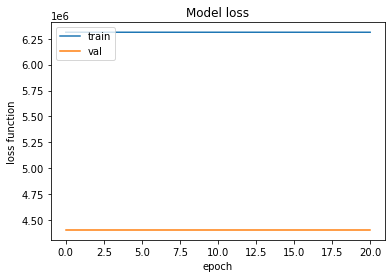

In [32]:
#hist = np.load('deephistories/hist_embed10_CV1.npy', allow_pickle=True).item()
log_path = "deep_logs/" + EXPORT_NAME + ".log"
hist = pd.read_csv(log_path,sep = ',',engine = 'python')

plt.figure()
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Model loss')
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

In [33]:
hist

,epoch,custom_mse,loss,val_custom_mse,val_loss
0,0,11671781.0,6312191.5,8115993.0,4406216.0
1,1,11671788.0,6312195.0,8115993.0,4406216.0
2,2,11671784.0,6312192.0,8115993.0,4406216.0
3,3,11671776.0,6312188.0,8115993.0,4406216.0
4,4,11671776.0,6312188.5,8115993.0,4406216.0
5,5,11671762.0,6312181.0,8115993.0,4406216.0
6,6,11671764.0,6312182.0,8115993.0,4406216.0
7,7,11671753.0,6312176.5,8115993.0,4406216.0
8,8,11671750.0,6312175.0,8115993.0,4406216.0
9,9,11671745.0,6312171.0,8115993.0,4406216.0
